In [23]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pyinterp

## Open datasets

In [24]:
dir_data = "/workspace/project/ssh_mapping/data/"

#### 1D observations 

In [25]:
path_obs = [
    f"{dir_data}/dc_obs/2020a_SSH_mapping_NATL60_envisat.nc",
    f"{dir_data}/dc_obs/2020a_SSH_mapping_NATL60_geosat2.nc",
    f"{dir_data}/dc_obs/2020a_SSH_mapping_NATL60_jason1.nc",
    f"{dir_data}/dc_obs/2020a_SSH_mapping_NATL60_topex-poseidon_interleaved.nc",
]

ds_obs = [xr.open_dataset(path) for path in path_obs]

#### 2D reference fields

In [26]:
ds_ref = xr.open_mfdataset(f"{dir_data}/dc_ref/*.nc")
ds_ref = ds_ref.assign_coords({ 'lon':('lon', ds_ref.lon.data % 360) }) # convert longitudes to [0,360]
ds_ref

<xarray.Dataset>
Dimensions:   (time: 8760, lat: 600, lon: 600)
Coordinates:
  * lon       (lon) float64 295.0 295.0 295.0 295.1 ... 304.9 305.0 305.0 305.0
  * lat       (lat) float64 33.02 33.03 33.05 33.07 ... 42.95 42.97 42.98 43.0
  * time      (time) datetime64[ns] 2012-10-01T00:30:00 ... 2013-09-30T23:30:00
Data variables:
    sossheig  (time, lat, lon) float32 dask.array<chunksize=(24, 600, 600), meta=np.ndarray>
Attributes:
    Info:     Horizontal grid read in regulargrid_NATL60.nc / Source field re...
    About:    Created by SOSIE interpolation environement => https://github.c...

## Create regular grid

In [27]:
# Create a regular grid for lon and lat
lon_min, lon_max = ds_ref.lon.min().values,ds_ref.lon.max().values
lat_min, lat_max = ds_ref.lat.min().values,ds_ref.lat.max().values
time_min, time_max = ds_ref.time.min().values,ds_ref.time.max().values
dlon = dlat = 0.1 # °
dt = 1 # days
lon_regular = np.arange(lon_min, lon_max, dlon)
lat_regular = np.arange(lat_min, lat_max, dlat)
# lon_regular = np.linspace(lon_min, lon_max, 224)
# lat_regular = np.linspace(lat_min, lat_max, 224)
lon_grid, lat_grid = np.meshgrid(lon_regular, lat_regular)
time_regular = np.arange(time_min, time_max, np.timedelta64(dt, 'D'))

## Projections

#### Binning observations

In [28]:
# Prepare a container for the new grid data
ssh_grid = np.empty((len(time_regular), lat_regular.size, lon_regular.size))

# Initialize binning object
binning = pyinterp.Binning2D(
    pyinterp.Axis(lon_regular, is_circle=True),
    pyinterp.Axis(lat_regular),
    )

# Interpolate data for each time step
for t_idx, time in enumerate(time_regular):

    binning.clear()

    # Loop on datasets
    lon1d = np.array([])
    lat1d = np.array([])
    ssh1d = np.array([])
    for _ds_obs in ds_obs:
        # Mask for the current time step within a tolerance
        mask = np.abs(_ds_obs.time - time) <= np.timedelta64(int(5*24*dt/2), 'h')
        _ds_obs_mask = _ds_obs.where(mask, drop=True)
        ssh1d = np.concatenate((ssh1d,_ds_obs_mask.ssh_model.values))
        lon1d = np.concatenate((lon1d,_ds_obs_mask.lon.values))
        lat1d = np.concatenate((lat1d,_ds_obs_mask.lat.values))

    # Binning data
    binning.push(lon1d,lat1d,ssh1d, True)

    ssh_grid[t_idx, :, :] = binning.variable('mean').T


# Create a new xarray dataset
ds_inputs = xr.Dataset(
    {
        "ssh": (["time", "lat", "lon"], ssh_grid)
    },
    coords={
        "time": time_regular,
        "lat": lat_regular,
        "lon": lon_regular
    }
)

# Save the new dataset
ds_inputs.to_netcdf("data_inputs_5days.nc")


ds_inputs.close()


In [29]:
ds_inputs

<xarray.Dataset>
Dimensions:  (time: 365, lat: 100, lon: 100)
Coordinates:
  * time     (time) datetime64[ns] 2012-10-01T00:30:00 ... 2013-09-30T00:30:00
  * lat      (lat) float64 33.02 33.12 33.22 33.32 ... 42.62 42.72 42.82 42.92
  * lon      (lon) float64 295.0 295.1 295.2 295.3 ... 304.6 304.7 304.8 304.9
Data variables:
    ssh      (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan

#### Regridding reference fields

In [30]:
# Define source grid
x_source_axis = pyinterp.Axis(ds_ref.lon.values, is_circle=True)
y_source_axis = pyinterp.Axis(ds_ref.lat.values)
z_source_axis = pyinterp.TemporalAxis(ds_ref.time.values)
grid_source = pyinterp.Grid3D(x_source_axis, y_source_axis, z_source_axis, ds_ref.sossheig.T)

# Define target grid
time_target = z_source_axis.safe_cast(np.ascontiguousarray(time_regular))
z_target = np.tile(time_target,(lon_regular.size,lat_regular.size,1))
nt = len(time_regular)
x_target = np.repeat(lon_grid.transpose()[:,:,np.newaxis],nt,axis=2)
y_target = np.repeat(lat_grid.transpose()[:,:,np.newaxis],nt,axis=2)

# Interpolation
ssh_interp = pyinterp.trivariate(grid_source,
                                x_target.flatten(),
                                y_target.flatten(),
                                z_target.flatten(),
                                bounds_error=False).reshape(x_target.shape).T

# Create a new xarray dataset
ds_target = xr.Dataset(
    {
        "ssh": (["time", "lat", "lon"], ssh_interp)
    },
    coords={
        "time": time_regular,
        "lat": lat_regular,
        "lon": lon_regular
    }
)

# Save the new dataset
ds_target.to_netcdf("data_target.nc")

print(ds_target)

ds_target.close()

<xarray.Dataset>
Dimensions:  (time: 365, lat: 100, lon: 100)
Coordinates:
  * time     (time) datetime64[ns] 2012-10-01T00:30:00 ... 2013-09-30T00:30:00
  * lat      (lat) float64 33.02 33.12 33.22 33.32 ... 42.62 42.72 42.82 42.92
  * lon      (lon) float64 295.0 295.1 295.2 295.3 ... 304.6 304.7 304.8 304.9
Data variables:
    ssh      (time, lat, lon) float64 0.5111 0.5266 0.5418 ... -0.1684 -0.1416


## Plot

In [31]:
ds_inputs = xr.open_dataset("data_inputs_5days.nc")
ds_target = xr.open_dataset("data_target.nc")

In [35]:
ds_target.sizes

Frozen({'time': 365, 'lat': 100, 'lon': 100})

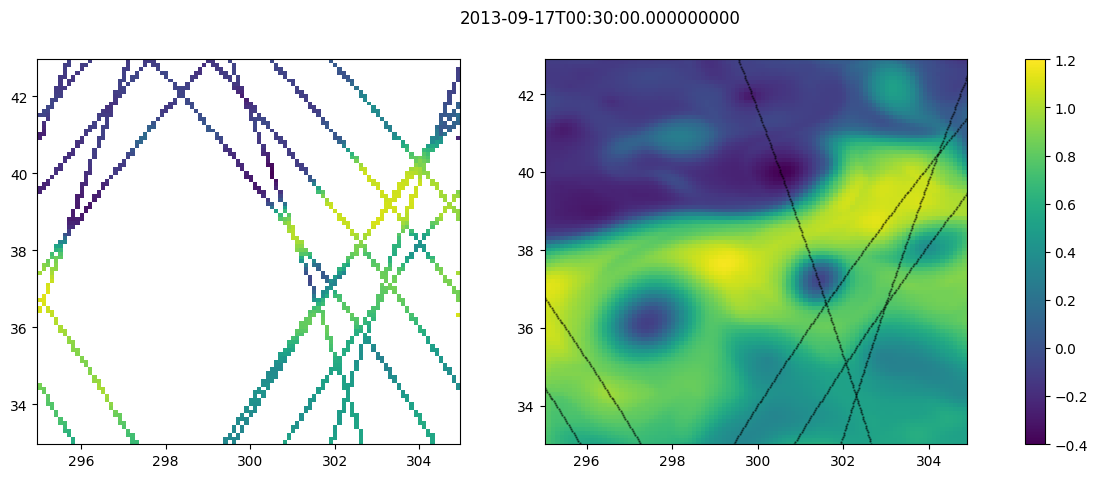

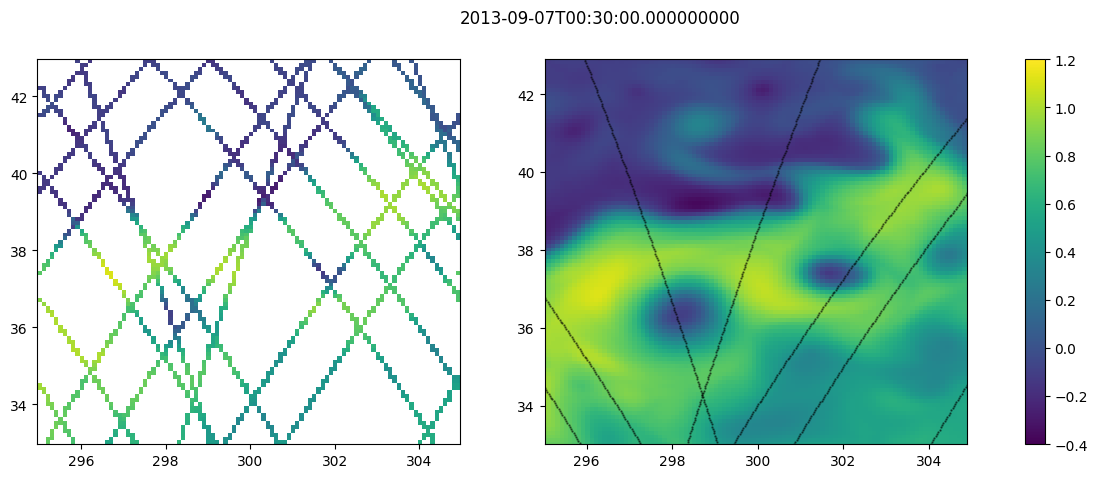

In [32]:
for _ in range(2):

    t = np.random.randint(0,365)

    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
    fig.suptitle(ds_inputs.time[t].values)

    im = ax1.pcolormesh(lon_regular, lat_regular, ds_inputs.ssh[t], vmin=-.4, vmax=1.2)
    ax2.pcolormesh(lon_regular, lat_regular, ds_target.ssh[t], vmin=-.4, vmax=1.2)
    for ds in ds_obs:
        _ds = ds.sel(time=slice(ds_inputs.time[t]-np.timedelta64(int(24*dt/2), 'h'), ds_inputs.time[t]+np.timedelta64(int(24*dt/2), 'h')))
        ax2.scatter(_ds.lon, _ds.lat, c='k', alpha=.5, s=0.5)
        ax2.set_xlim([lon_min,lon_max-.1])
        ax2.set_ylim([lat_min,lat_max-.1])

    plt.colorbar(im, ax=(ax1,ax2))
    plt.show()

## Data Exploration

In [14]:
print(ds_inputs["ssh"].shape)
print(ds_target["ssh"].shape)

(365, 224, 224)
(365, 224, 224)


In [83]:
print(f'Start date of ds_inputs: {ds_inputs["ssh"].time[0].values}')
print(f'Start date of ds_inputs: {ds_inputs["ssh"].time[-1].values}')

Start date of ds_inputs: 2012-10-01T00:30:00.000000000
Start date of ds_inputs: 2013-09-30T00:30:00.000000000


In [79]:
total_nan = ds_inputs["ssh"].isnull().sum()
ratio = total_nan.values * 100 / ds_inputs["ssh"].size
print(f'Total number of NaN in ds_inputs: {total_nan.values}')
print(f'Total number data in ds_inputs: {ds_inputs["ssh"].size}')
print(f'Ratio of NaN values: {ratio}')

Total number of NaN in ds_inputs: 3515147
Total number data in ds_inputs: 3650000
Ratio of NaN values: 96.30539726027398


31
2012-11-01T00:30:00.000000000


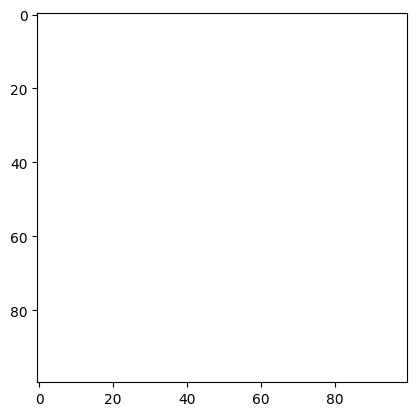

In [81]:
nan_values = []
array_size = ds_inputs["ssh"].shape[1] * ds_inputs["ssh"].shape[2]
for index in range(ds_inputs["ssh"].shape[0]):

    if ds_inputs["ssh"][index].isnull().sum().values == array_size:
        nan_values.append(index)
        print(index)
        print(ds_inputs["ssh"].time[index].values)
        plt.imshow(ds_inputs["ssh"][index])

    else:
        nan_values.append(0)

Maybe need to remove this data later use the one from h -1 or h + 1

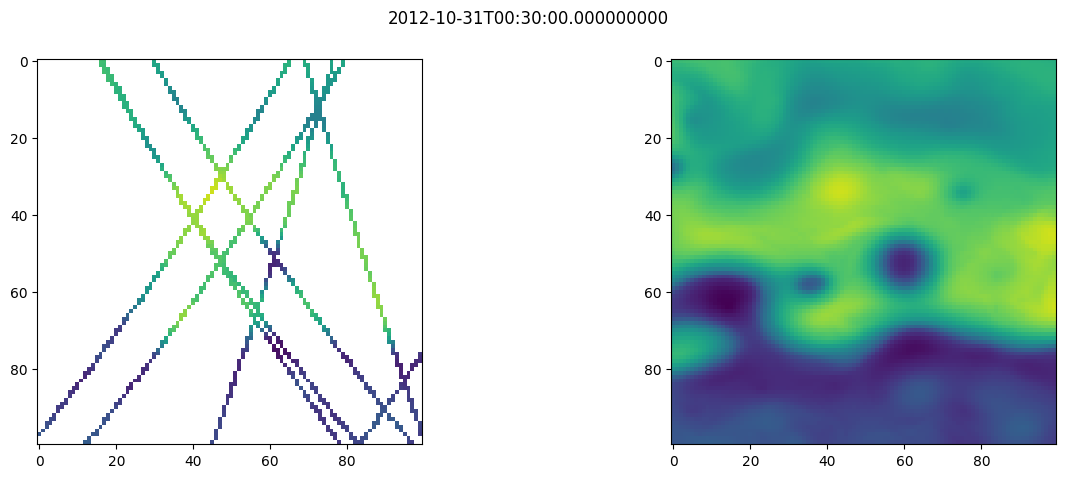

In [86]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
fig.suptitle(ds_inputs.time[30].values)
ax1.imshow(ds_inputs.ssh[30], vmin=-.4, vmax=1.2)
ax2.imshow(ds_target.ssh[30], vmin=-.4, vmax=1.2)
plt.show()

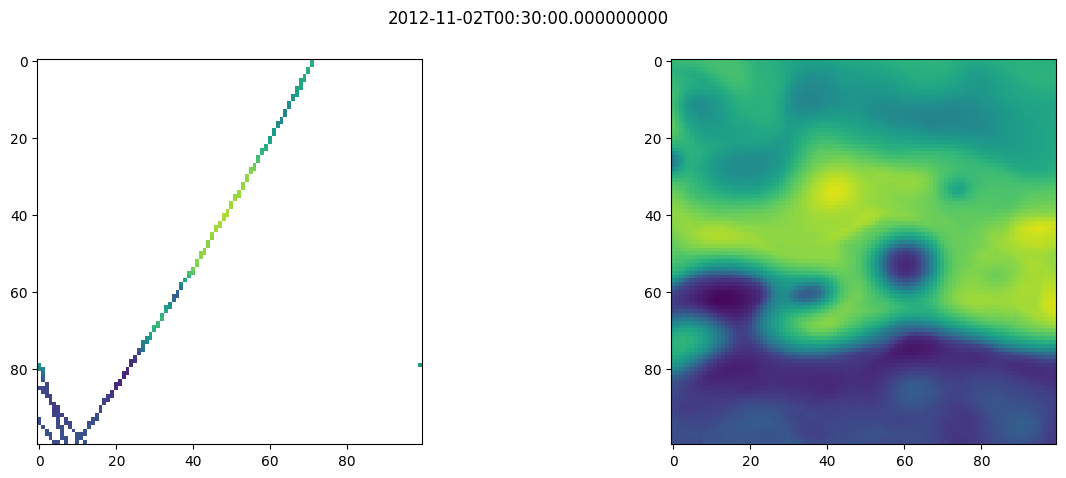

In [88]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
fig.suptitle(ds_inputs.time[32].values)
ax1.imshow(ds_inputs.ssh[32].values, vmin=-.4, vmax=1.2)
ax2.imshow(ds_target.ssh[32].values, vmin=-.4, vmax=1.2)
plt.show()

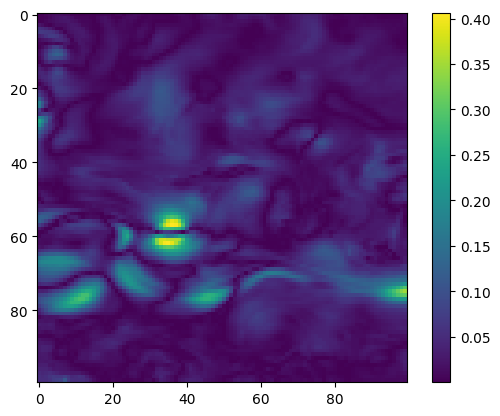

In [95]:
plt.imshow(np.abs(ds_target.ssh[32].values-ds_target.ssh[30].values))
plt.colorbar()
plt.show()

In [42]:
import xarray as xr
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import transforms

# Load the datasets
ds_inputs = xr.open_dataset("data_inputs_5days.nc")
ds_target = xr.open_dataset("data_target.nc")

# Assuming the datasets have dimensions 'time', 'lat', and 'lon'
time_dim = ds_inputs.dims['time']
lat_dim = ds_inputs.dims['lat']
lon_dim = ds_inputs.dims['lon']

# Check the dimensions to ensure they match your description
print(ds_inputs.dims)  # Should print {'time': 365, 'lat': 100, 'lon': 100}
print(ds_target.dims)  # Should print {'time': 365, 'lat': 100, 'lon': 100}

# Convert the datasets to numpy arrays
data_inputs = ds_inputs.to_array().values[0]  # Assuming there's only one variable, hence values[0]
data_target = ds_target.to_array().values[0]  # Assuming there's only one variable, hence values[0]

# Create new datasets with depth of 10 days
depth = 10
new_inputs = []
new_target = []

for i in range(0, time_dim - depth + 1):
    input_slice = data_inputs[i:i+depth, :, :]
    target_slice = data_target[i:i+depth, :, :]
    new_inputs.append(input_slice)
    new_target.append(target_slice)

new_inputs = np.array(new_inputs)
new_target = np.array(new_target)

# Define the custom dataset class for 3D CNNs
class TrainDataset3D(Dataset):
    def __init__(self, ds_inputs, ds_target):
        self.ds_inputs = ds_inputs
        self.ds_target = ds_target

    def __getitem__(self, index):
        x = self.ds_inputs[index]  # 3D numpy array (depth, height, width)
        y = self.ds_target[index]  # 3D numpy array (depth, height, width)

        # Normalize the data
        y_norm = (y - y.min()) / (y.max() - y.min()) + 0.01
        x_norm = (x - y.min()) / (y.max() - y.min()) + 0.01
        x_norm[np.isnan(x_norm)] = 0.001

        # Transform to tensors
        transform = transforms.Compose([
            transforms.ToTensor()
        ])
        x_norm = transform(x_norm)
        y_norm = torch.tensor(y_norm, dtype=torch.float32).unsqueeze(0)

        return x_norm, y_norm

    def __len__(self):
        return len(self.ds_inputs)

# Instantiate the dataset
train_dataset = TrainDataset3D(new_inputs, new_target)

# Example usage with DataLoader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=False)

# Iterate through the DataLoader
for x_norm, y_norm in train_loader:
    print(x_norm.shape, y_norm.shape)
    # Should print torch.Size([8, 1, 10, 100, 100]) for x_norm and torch.Size([8, 1, 10, 100, 100]) for y_norm


Frozen({'time': 365, 'lat': 100, 'lon': 100})
Frozen({'time': 365, 'lat': 100, 'lon': 100})
torch.Size([8, 100, 10, 100]) torch.Size([8, 1, 10, 100, 100])
torch.Size([8, 100, 10, 100]) torch.Size([8, 1, 10, 100, 100])
torch.Size([8, 100, 10, 100]) torch.Size([8, 1, 10, 100, 100])
torch.Size([8, 100, 10, 100]) torch.Size([8, 1, 10, 100, 100])
torch.Size([8, 100, 10, 100]) torch.Size([8, 1, 10, 100, 100])
torch.Size([8, 100, 10, 100]) torch.Size([8, 1, 10, 100, 100])
torch.Size([8, 100, 10, 100]) torch.Size([8, 1, 10, 100, 100])
torch.Size([8, 100, 10, 100]) torch.Size([8, 1, 10, 100, 100])
torch.Size([8, 100, 10, 100]) torch.Size([8, 1, 10, 100, 100])
torch.Size([8, 100, 10, 100]) torch.Size([8, 1, 10, 100, 100])
torch.Size([8, 100, 10, 100]) torch.Size([8, 1, 10, 100, 100])
torch.Size([8, 100, 10, 100]) torch.Size([8, 1, 10, 100, 100])
torch.Size([8, 100, 10, 100]) torch.Size([8, 1, 10, 100, 100])
torch.Size([8, 100, 10, 100]) torch.Size([8, 1, 10, 100, 100])
torch.Size([8, 100, 10, 10

In [54]:
import torch
from torch import nn

class AutoencoderCNN3D(nn.Module):
    def __init__(self):
        super(AutoencoderCNN3D, self).__init__()

        # Encoder
        self.conv1 = nn.Conv3d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv3d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

        self.conv3 = nn.Conv3d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()

        self.conv4 = nn.Conv3d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.relu4 = nn.ReLU()

        self.conv5 = nn.Conv3d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.relu5 = nn.ReLU()

        self.conv6 = nn.Conv3d(in_channels=256, out_channels=1, kernel_size=3, stride=1, padding=1)

        # Decoder
        self.deconv1 = nn.ConvTranspose3d(in_channels=1, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.relu6 = nn.ReLU()

        self.deconv2 = nn.ConvTranspose3d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.relu7 = nn.ReLU()

        self.deconv3 = nn.ConvTranspose3d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu8 = nn.ReLU()

        self.deconv4 = nn.ConvTranspose3d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu9 = nn.ReLU()

        self.deconv5 = nn.ConvTranspose3d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu10 = nn.ReLU()

        self.deconv6 = nn.ConvTranspose3d(in_channels=16, out_channels=1, kernel_size=(3,3,3) , stride=(1,1,1), padding=(1,1,1))

        self.relu11 = nn.ReLU()
        self.deconv7 = nn.ConvTranspose3d(in_channels=1, out_channels=1, kernel_size=(1,1,1) , stride=(1,1,1), padding=(1,1,1))

    def forward(self, x):
        # Encoder
        x = self.conv1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.relu2(x)

        x = self.conv3(x)
        x = self.relu3(x)

        x = self.conv4(x)
        x = self.relu4(x)

        x = self.conv5(x)
        x = self.relu5(x)

        x = self.conv6(x)

        # Decoder
        x = self.deconv1(x)
        x = self.relu6(x)

        x = self.deconv2(x)
        x = self.relu7(x)

        x = self.deconv3(x)
        x = self.relu8(x)

        x = self.deconv4(x)
        x = self.relu9(x)

        x = self.deconv5(x)
        x = self.relu10(x)
        print(x.shape)
        x = self.deconv6(x)

        x = self.relu11(x)
        print(x.shape)
        x = self.deconv7(x)
        print(x.shape)
        return x


In [57]:
x = torch.rand((8, 1, 6, 100, 100))
model = AutoencoderCNN3D()
out = model(x)

In [14]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models


def weights_init(init_type='gaussian'):
    def init_fun(m):
        classname = m.__class__.__name__
        if (classname.find('Conv') == 0 or classname.find(
                'Linear') == 0) and hasattr(m, 'weight'):
            if init_type == 'gaussian':
                nn.init.normal_(m.weight, 0.0, 0.02)
            elif init_type == 'xavier':
                nn.init.xavier_normal_(m.weight, gain=math.sqrt(2))
            elif init_type == 'kaiming':
                nn.init.kaiming_normal_(m.weight, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                nn.init.orthogonal_(m.weight, gain=math.sqrt(2))
            elif init_type == 'default':
                pass
            else:
                assert 0, "Unsupported initialization: {}".format(init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias, 0.0)

    return init_fun


class VGG16FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        vgg16 = models.vgg16(pretrained=True)
        self.enc_1 = nn.Sequential(*vgg16.features[:5])
        self.enc_2 = nn.Sequential(*vgg16.features[5:10])
        self.enc_3 = nn.Sequential(*vgg16.features[10:17])

        # fix the encoder
        for i in range(3):
            for param in getattr(self, 'enc_{:d}'.format(i + 1)).parameters():
                param.requires_grad = False

    def forward(self, image):
        results = [image]
        for i in range(3):
            func = getattr(self, 'enc_{:d}'.format(i + 1))
            results.append(func(results[-1]))
        return results[1:]


class PartialConv3D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(PartialConv3D, self).__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size, stride, padding)
        self.mask_update_conv = nn.Conv3d(in_channels, out_channels, kernel_size, stride, padding, bias=False)

        # Initialize the mask update convolution weights to ones
        torch.nn.init.constant_(self.mask_update_conv.weight, 1.0)
        self.mask_update_conv.weight.requires_grad = False

    def forward(self, x, mask):
        # Apply convolution to the valid pixels
        x = x * mask  # Mask the input x

        # Perform the convolution
        output = self.conv(x)

        # Normalize the output by the sum of the mask values
        mask_sum = self.mask_update_conv(mask)
        mask_sum = mask_sum.masked_fill_(mask_sum == 0, 1.0)  # Avoid division by zero
        output = output / mask_sum

        # Update the mask
        new_mask = self.mask_update_conv(mask)
        new_mask = (new_mask > 0).float()

        return output, new_mask


class PCBActiv(nn.Module):
    def __init__(self, in_ch, out_ch, bn=True, sample='none-3', activ='relu',
                 conv_bias=False):
        super().__init__()
        if sample == 'down-5':
            self.conv = PartialConv(in_ch, out_ch, 5, 2, 2, bias=conv_bias)
        elif sample == 'down-7':
            self.conv = PartialConv(in_ch, out_ch, 7, 2, 3, bias=conv_bias)
        elif sample == 'down-3':
            self.conv = PartialConv(in_ch, out_ch, 3, 2, 1, bias=conv_bias)
        else:
            self.conv = PartialConv(in_ch, out_ch, 3, 1, 1, bias=conv_bias)

        if bn:
            self.bn = nn.BatchNorm3d(out_ch)
        if activ == 'relu':
            self.activation = nn.ReLU()
        elif activ == 'leaky':
            self.activation = nn.LeakyReLU(negative_slope=0.2)

    def forward(self, input, input_mask):
        h, h_mask = self.conv(input, input_mask)
        if hasattr(self, 'bn'):
            h = self.bn(h)
        if hasattr(self, 'activation'):
            h = self.activation(h)
        return h, h_mask


class PConvUNet(nn.Module):
    def __init__(self, layer_size=7, input_channels=1, upsampling_mode='nearest'):
        super().__init__()
        self.freeze_enc_bn = False
        self.upsampling_mode = upsampling_mode
        self.layer_size = layer_size
        self.enc_1 = PCBActiv(input_channels, 64, bn=False, sample='down-7')
        self.enc_2 = PCBActiv(64, 128, sample='down-5')
        self.enc_3 = PCBActiv(128, 256, sample='down-5')
        self.enc_4 = PCBActiv(256, 512, sample='down-3')
        for i in range(4, self.layer_size):
            name = 'enc_{:d}'.format(i + 1)
            setattr(self, name, PCBActiv(512, 512, sample='down-3'))

        for i in range(4, self.layer_size):
            name = 'dec_{:d}'.format(i + 1)
            setattr(self, name, PCBActiv(512 + 512, 512, activ='leaky'))
        self.dec_4 = PCBActiv(512 + 256, 256, activ='leaky')
        self.dec_3 = PCBActiv(256 + 128, 128, activ='leaky')
        self.dec_2 = PCBActiv(128 + 64, 64, activ='leaky')
        self.dec_1 = PCBActiv(64 + input_channels, input_channels,
                              bn=False, activ=None, conv_bias=True)

    def forward(self, input, input_mask):
        h_dict = {}  # for the output of enc_N
        h_mask_dict = {}  # for the output of enc_N

        h_dict['h_0'], h_mask_dict['h_0'] = input, input_mask

        h_key_prev = 'h_0'
        for i in range(1, self.layer_size + 1):
            l_key = 'enc_{:d}'.format(i)
            h_key = 'h_{:d}'.format(i)
            h_dict[h_key], h_mask_dict[h_key] = getattr(self, l_key)(
                h_dict[h_key_prev], h_mask_dict[h_key_prev])
            h_key_prev = h_key

        h_key = 'h_{:d}'.format(self.layer_size)
        h, h_mask = h_dict[h_key], h_mask_dict[h_key]

        # concat upsampled output of h_enc_N-1 and dec_N+1, then do dec_N
        # (exception)
        #                            input         dec_2            dec_1
        #                            h_enc_7       h_enc_8          dec_8

        for i in range(self.layer_size, 0, -1):
            enc_h_key = 'h_{:d}'.format(i - 1)
            dec_l_key = 'dec_{:d}'.format(i)

            h = F.interpolate(h, scale_factor=2, mode=self.upsampling_mode)
            h_mask = F.interpolate(
                h_mask, scale_factor=2, mode='nearest')

            h = torch.cat([h, h_dict[enc_h_key]], dim=1)
            h_mask = torch.cat([h_mask, h_mask_dict[enc_h_key]], dim=1)
            h, h_mask = getattr(self, dec_l_key)(h, h_mask)

        return h, h_mask

    def train(self, mode=True):
        """
        Override the default train() to freeze the BN parameters
        """
        super().train(mode)
        if self.freeze_enc_bn:
            for name, module in self.named_modules():
                if isinstance(module, nn.BatchNorm2d) and 'enc' in name:
                    module.eval()


if __name__ == '__main__':
    size = (1, 3, 10, 5, 5)
    input = torch.ones(size)
    input_mask = torch.ones(size)
    input_mask[:, :, :, 2:, :][:, :, :, :, 2:] = 0

    # conv = PartialConv(3, 3, 3, 1, 1)
    # l1 = nn.L1Loss()
    # input.requires_grad = True

    output, output_mask = conv(input, input_mask)
    loss = l1(output, torch.randn(1, 3, 5, 5))
    loss.backward()

    # model = PConvUNet()
    # output, output_mask = model(input, input_mask)

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [1, 3, 10, 5, 5]

In [3]:
output.shape

torch.Size([1, 3, 5, 5])

In [15]:
input_mask.shape


torch.Size([1, 3, 10, 5, 5])